# Часть 3. Выбор и обучение модели

In [29]:
import pandas as pd
import numpy as np
import pickle                                                        #для сохранения модели
from sklearn.model_selection import train_test_split                 #для разбиения данных на выборки
from sklearn import metrics                                          #метрики
from sklearn.linear_model import LinearRegression                    #линейная регрессия
from sklearn.ensemble import RandomForestRegressor                   #случайный лес
from sklearn.ensemble import GradientBoostingRegressor               #градиентный бустинг
import xgboost
# визуальная составляющая
import matplotlib.pyplot as plt
%matplotlib inline

Проверим разные алгоритмы и сравним их показатели. Кроме того, посмотрим показатели на разных датасетах: полном и сокращенном

In [356]:
#зафиксируем параметры
RANDOM_SEED = 34
TEST_SIZE=0.2

#загружаем датасеты для обучения
data = pd.read_csv('data4ml_5.csv')  #датасет с удаленными колонками после feature-selector

In [357]:
data['sqft_lot'] = data['sqft']+data['lot']

In [358]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374347 entries, 0 to 374346
Data columns (total 36 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   1                    374347 non-null  float64
 1   K                    374347 non-null  float64
 2   min_dist             374347 non-null  float64
 3   Remodeled            374347 non-null  int64  
 4   state_mean           374347 non-null  float64
 5   street_hash          374347 non-null  int64  
 6   new_id               374347 non-null  int64  
 7   prop_type            374347 non-null  int64  
 8   schools_count        374347 non-null  float64
 9   max_dist             374347 non-null  float64
 10  11                   374347 non-null  float64
 11  zipcode_int          374347 non-null  int64  
 12  mean_dist            374347 non-null  float64
 13  address_hash         374347 non-null  int64  
 14  sqft                 374347 non-null  int64  
 15  8                

In [359]:
#разделяем датасеты на данные и целевую переменную, отбрасывая при этом стоимость за кв. фут
columns = list(set(data.columns) - set(['target', 'price_sqft', 'price', 'price_lot']))
X = data[columns]
y = data['target']

## Метрики для оценивания результата

### MAPE - "Mean Absolute Percentage Error" - Средняя абсолютная процентная ошибка

коэффициент, не имеющий размерности, с очень простой интерпретацией. Его можно измерять в долях или процентах. Если у вас получилось, например, что MAPE=11.4%, то это говорит о том, что ошибка составила 11,4% от фактических значений. 

Коэффициент по разному относится к положительным и отрицательным ошибкам. этот коэффициент жестче относится к случаям завышенных прогнозов, чем заниженных. В случае с агрегированием прогнозов по разным значениям, это приводит к искажениям - прогнозист не получает достоверной информации о том, насколько его прогноз точен. 

### коэффициент SMAPE - "Symmetric MAPE"

Трактовка у коэффициента примерно такая же, как и у MAPE: какой процент составляет ошибка от этой самой величины.

Коэффициент должен бы быть симметричным, но таковым до конца не является. 

In [199]:
#функция для вычисления процента ошибки
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [278]:
def SMAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(2*np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

# Вычислим стоимость без машинного обучения

Пример, если брать просто среднюю стоимость дома по всей выборке. Процент ошибки = 83%

In [305]:
new_price = data_2['target'].mean()
data_2['new_target'] = new_price
print('средняя стоимость дома по всей выборке', new_price)
print('MAE:', metrics.mean_absolute_error(data_2['target'], data_2['new_target']))
print('RMSE:', np.sqrt(metrics.mean_squared_error(data_2['target'], data_2['new_target'])))
print('R2-score', metrics.r2_score(data_2['target'], data_2['new_target']))
print('MAPE', MAPE(data_2['target'], data_2['new_target']))
print('SMAPE', SMAPE(data_2['target'], data_2['new_target']))

средняя стоимость дома по всей выборке 644821.6591585415
MAE: 580567.0502524216
RMSE: 1842064.6815025436
R2-score 0.0
MAPE 7.951030727669823
SMAPE 0.8360365446875936


Пример, если брать среднюю стоимость по округу (по почтовому индексу). Ошибка уже 53%

In [291]:
by_column = 'zipcode_int' #'state_encoding' #'zipcode_int'
data_mean_price = data.groupby(by = by_column).mean()['target']
data_new = data.merge(data_mean_price, how = 'left', on = by_column)
#data_new['new_price'] = data_mean_price # data_new['price_y'] * data_new['sqft']

print('MAE:', metrics.mean_absolute_error(data_new['target_x'], data_new['target_y']))
print('RMSE:', np.sqrt(metrics.mean_squared_error(data_new['target_x'], data_new['target_y'])))
print('R2-score:', metrics.r2_score(data_new['target_x'], data_new['target_y']))
print('MAPE:', MAPE(data_new['target_x'], data_new['target_y']))
print('SMAPE:', SMAPE(data_new['target_x'], data_new['target_y']))

MAE: 412702.06175783696
RMSE: 1604803.5220831006
R2-score: 0.24101361376439379
MAPE: 3.5322589863274425
SMAPE: 0.5383571056744821


In [306]:
data_mean_price

zipcode_int
0            1.052333e+07
1103         9.700000e+04
1104         1.412411e+05
1105         1.238595e+05
1106         8.028900e+04
                 ...     
277139677    2.850000e+05
277139782    2.750000e+05
277139791    4.490000e+05
770152522    1.399990e+05
770925540    1.300000e+05
Name: target, Length: 4488, dtype: float64

### Рассмотрим несколько алгоритмов и сравним результаты их работы

## Линейная регрессия

In [363]:
#разделяем датасет на тренировочную и валидационные части
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=TEST_SIZE, random_state = RANDOM_SEED)

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
y_pred_lin =  lin_reg.predict(X_test)
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика Mean Absolute Error (MAE) показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_lin))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_lin)))
print('R2-score', metrics.r2_score(y_test, y_pred_lin))
print('MAPE', MAPE(y_test, y_pred_lin))
print('SMAPE', SMAPE(y_test, y_pred_lin))

#как видим, в среднем ошибка очень большая, что совсем нас не устраивает

MAE: 548717.2122941865
RMSE: 1673833.0420650712
R2-score 0.18963474742825825
MAPE 3.6481582464261395
SMAPE 0.9157253948751257


Процент ошибки велик. Даже больше, чем для простого округления. Кроме того, слишком велика абсолютная ошибка (МАЕ)

## Случайный лес

In [362]:
#разделяем датасет на тренировочную и валидационные части
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=TEST_SIZE, random_state = RANDOM_SEED)

model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)


print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2-score', metrics.r2_score(y_test, y_pred))
print('MAPE', MAPE(y_test, y_pred))
print('SMAPE', SMAPE(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s


MAE: 221576.57808414582
RMSE: 1111151.3391791964
R2-score 0.642889215875833
MAPE 0.8889283131478276
SMAPE 0.283993251510035


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


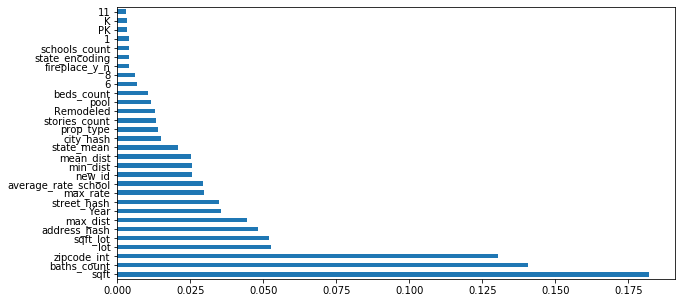

In [364]:
#посмотрим, какие колонки вносят больший вклад
plt.rcParams['figure.figsize'] = (10,5)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')

## gradient boosting

Проведем процедуру подбора наилучших гиперпараметров перед непосредственно обучением модели

In [33]:
from sklearn.model_selection import GridSearchCV
#подбор гиперпараметров
parameters = {'n_estimators':[30, 50,100], 'learning_rate':[0.1], 'max_depth': [15,20],
             'min_samples_leaf': [2], 'random_state': [RANDOM_SEED]}

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=TEST_SIZE, random_state = RANDOM_SEED)
gbrt_search = GradientBoostingRegressor()
search = GridSearchCV(gbrt_search, parameters, verbose =1)
search.fit(X_train,y_train)
best_param = search.best_estimator_
best_param


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 252.2min finished


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=15,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=2, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=34, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Обучение

In [366]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=TEST_SIZE, random_state = RANDOM_SEED)
gbrt = GradientBoostingRegressor(max_depth=15, n_estimators=100, 
                                 min_samples_leaf = 2, learning_rate=0.1,random_state = RANDOM_SEED,
                                 verbose =0)
gbrt.fit(X_train,y_train)
y_pred_gbrt = gbrt.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_gbrt))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_gbrt)))
print('R2-score', metrics.r2_score(y_test, y_pred_gbrt))
print('MAPE', MAPE(y_test, y_pred_gbrt))
print('SMAPE', SMAPE(y_test, y_pred_gbrt))

MAE: 223551.89919662432
RMSE: 1165293.9933987588
R2-score 0.6072397272092372
MAPE 0.935749838613261
SMAPE 0.31756624184134474


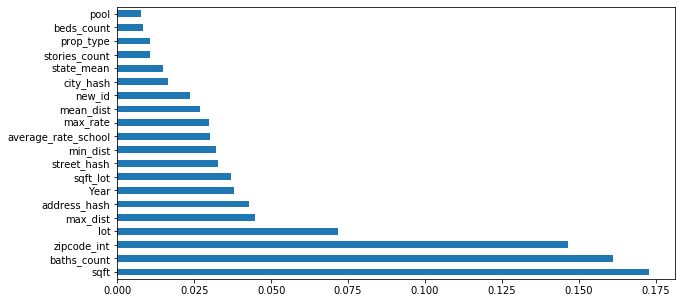

In [367]:
#посмотрим, какие колонки вносят больший вклад
plt.rcParams['figure.figsize'] = (10,5)
feat_importances = pd.Series(gbrt.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

# Voting

In [35]:
from sklearn.ensemble import VotingRegressor

X_train, X_test, y_train, y_test = train_test_split(X_2,y_2, test_size=TEST_SIZE, random_state = RANDOM_SEED)

reg1 = GradientBoostingRegressor(max_depth=15, n_estimators=100, 
                                 min_samples_leaf = 2, learning_rate=0.1,random_state = RANDOM_SEED,
                                 verbose =0)
reg2 = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
reg3 = LinearRegression()
ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
ereg = ereg.fit(X_train, y_train)

y_pred = ereg.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2-score', metrics.r2_score(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s


MAE: 103573.50763276432
RMSE: 750516.1878318249
R2-score 0.8393842156795602


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


# XGBoost

In [365]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=TEST_SIZE, random_state = RANDOM_SEED)

for i in ['gbtree', 'gblinear','dart']:
    xgb = xgboost.XGBRegressor(n_estimators = 100, max_depth = 20, learning_rate = 0.1, booster = i, random_state = RANDOM_SEED)
    xgb.fit(X_train,y_train)
    y_pred_xgb = xgb.predict(X_test)
    print(i)
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred_xgb))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgb)))
    print('R2-score', metrics.r2_score(y_test, y_pred_xgb))
    print('MAPE', MAPE(y_test, y_pred_xgb))
    print('SMAPE', SMAPE(y_test, y_pred_xgb))
    print(' ============= ')
    

gbtree
MAE: 212122.3073335078
RMSE: 1158553.943132343
R2-score 0.6117700315548119
MAPE 0.8094093488604587
SMAPE 0.28185594705220585
[22:40:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


gblinear
MAE: 532910.6639006374
RMSE: 1693010.4380340567
R2-score 0.1709593823727652
MAPE 3.6236323476533805
SMAPE 0.8518893701306831
dart
MAE: 212179.006705499
RMSE: 1158558.8660637725
R2-score 0.6117667322115479
MAPE 0.8113899608042641
SMAPE 0.2821272460205321


# LightGBM

In [370]:
import lightgbm as lgb

In [371]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=TEST_SIZE, random_state = RANDOM_SEED)
#X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size=TEST_SIZE, random_state = RANDOM_SEED)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

num_round = 1000
param = {'num_leaves': 31, 
         'objective': 'mae', 
         'max_depth': 20, 
         'min_data_in_leaf': 20,
         'bagging_fraction': 0.4,
         'tree_learner':'voting'}
param['metric'] = ['mape', 'rmse', 'mae']

for i in ['mape', 'rmse', 'mae']:
    param['objective'] = i
    bst = lgb.train(param, train_data, num_round, valid_sets=test_data)
    y_pred_bst = bst.predict(X_test)
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred_bst))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_bst)))
    print('R2-score', metrics.r2_score(y_test, y_pred_bst))
    print('MAPE', MAPE(y_test, y_pred_bst))
    print('SMAPE', SMAPE(y_test, y_pred_bst))

[1]	valid_0's mape: 0.938882	valid_0's rmse: 1.9638e+06	valid_0's l1: 631937
[2]	valid_0's mape: 0.910974	valid_0's rmse: 1.9606e+06	valid_0's l1: 622092
[3]	valid_0's mape: 0.888967	valid_0's rmse: 1.95778e+06	valid_0's l1: 613323
[4]	valid_0's mape: 0.871504	valid_0's rmse: 1.95527e+06	valid_0's l1: 605527
[5]	valid_0's mape: 0.841961	valid_0's rmse: 1.95262e+06	valid_0's l1: 597221
[6]	valid_0's mape: 0.81744	valid_0's rmse: 1.95029e+06	valid_0's l1: 589872
[7]	valid_0's mape: 0.8083	valid_0's rmse: 1.94864e+06	valid_0's l1: 584691
[8]	valid_0's mape: 0.794061	valid_0's rmse: 1.94694e+06	valid_0's l1: 579549
[9]	valid_0's mape: 0.791642	valid_0's rmse: 1.94681e+06	valid_0's l1: 579163
[10]	valid_0's mape: 0.789724	valid_0's rmse: 1.9467e+06	valid_0's l1: 578817
[11]	valid_0's mape: 0.787748	valid_0's rmse: 1.94648e+06	valid_0's l1: 578127
[12]	valid_0's mape: 0.771406	valid_0's rmse: 1.94458e+06	valid_0's l1: 572207
[13]	valid_0's mape: 0.757887	valid_0's rmse: 1.94292e+06	valid_0's

[106]	valid_0's mape: 0.643492	valid_0's rmse: 1.92019e+06	valid_0's l1: 506342
[107]	valid_0's mape: 0.64349	valid_0's rmse: 1.9202e+06	valid_0's l1: 506349
[108]	valid_0's mape: 0.643496	valid_0's rmse: 1.92019e+06	valid_0's l1: 506350
[109]	valid_0's mape: 0.643494	valid_0's rmse: 1.9202e+06	valid_0's l1: 506356
[110]	valid_0's mape: 0.643493	valid_0's rmse: 1.9202e+06	valid_0's l1: 506361
[111]	valid_0's mape: 0.643499	valid_0's rmse: 1.9202e+06	valid_0's l1: 506361
[112]	valid_0's mape: 0.643498	valid_0's rmse: 1.9202e+06	valid_0's l1: 506365
[113]	valid_0's mape: 0.643497	valid_0's rmse: 1.9202e+06	valid_0's l1: 506368
[114]	valid_0's mape: 0.643497	valid_0's rmse: 1.9202e+06	valid_0's l1: 506371
[115]	valid_0's mape: 0.643496	valid_0's rmse: 1.9202e+06	valid_0's l1: 506374
[116]	valid_0's mape: 0.643496	valid_0's rmse: 1.9202e+06	valid_0's l1: 506377
[117]	valid_0's mape: 0.643496	valid_0's rmse: 1.9202e+06	valid_0's l1: 506379
[118]	valid_0's mape: 0.643495	valid_0's rmse: 1.92

[210]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[211]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[212]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[213]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[214]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[215]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[216]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[217]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[218]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[219]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[220]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[221]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[222]	valid_0's mape: 0.643493	valid_0's

[314]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[315]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[316]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[317]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[318]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[319]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[320]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[321]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[322]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[323]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[324]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[325]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[326]	valid_0's mape: 0.643493	valid_0's

[417]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[418]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[419]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[420]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[421]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[422]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[423]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[424]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[425]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[426]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[427]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[428]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[429]	valid_0's mape: 0.643493	valid_0's

[519]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[520]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[521]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[522]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[523]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[524]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[525]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[526]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[527]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[528]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[529]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[530]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[531]	valid_0's mape: 0.643493	valid_0's

[621]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[622]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[623]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[624]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[625]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[626]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[627]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[628]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[629]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[630]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[631]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[632]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[633]	valid_0's mape: 0.643493	valid_0's

[723]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[724]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[725]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[726]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[727]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[728]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[729]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[730]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[731]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[732]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[733]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[734]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[735]	valid_0's mape: 0.643493	valid_0's

[827]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[828]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[829]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[830]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[831]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[832]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[833]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[834]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[835]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[836]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[837]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[838]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[839]	valid_0's mape: 0.643493	valid_0's

[931]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[932]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[933]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[934]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[935]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[936]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[937]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[938]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[939]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[940]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[941]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[942]	valid_0's mape: 0.643493	valid_0's rmse: 1.92021e+06	valid_0's l1: 506400
[943]	valid_0's mape: 0.643493	valid_0's

[39]	valid_0's mape: 2.51078	valid_0's rmse: 1.18883e+06	valid_0's l1: 324520
[40]	valid_0's mape: 2.46638	valid_0's rmse: 1.18576e+06	valid_0's l1: 322407
[41]	valid_0's mape: 2.45074	valid_0's rmse: 1.18483e+06	valid_0's l1: 321824
[42]	valid_0's mape: 2.42165	valid_0's rmse: 1.17882e+06	valid_0's l1: 320948
[43]	valid_0's mape: 2.36825	valid_0's rmse: 1.17522e+06	valid_0's l1: 319584
[44]	valid_0's mape: 2.35568	valid_0's rmse: 1.17275e+06	valid_0's l1: 317574
[45]	valid_0's mape: 2.33612	valid_0's rmse: 1.17165e+06	valid_0's l1: 316662
[46]	valid_0's mape: 2.29867	valid_0's rmse: 1.16983e+06	valid_0's l1: 315432
[47]	valid_0's mape: 2.28074	valid_0's rmse: 1.16614e+06	valid_0's l1: 314504
[48]	valid_0's mape: 2.27266	valid_0's rmse: 1.1646e+06	valid_0's l1: 313472
[49]	valid_0's mape: 2.22975	valid_0's rmse: 1.16322e+06	valid_0's l1: 312327
[50]	valid_0's mape: 2.22747	valid_0's rmse: 1.16139e+06	valid_0's l1: 311955
[51]	valid_0's mape: 2.2008	valid_0's rmse: 1.16009e+06	valid_0's

[146]	valid_0's mape: 1.52441	valid_0's rmse: 1.09602e+06	valid_0's l1: 279461
[147]	valid_0's mape: 1.52948	valid_0's rmse: 1.09605e+06	valid_0's l1: 279468
[148]	valid_0's mape: 1.52181	valid_0's rmse: 1.09539e+06	valid_0's l1: 279160
[149]	valid_0's mape: 1.52422	valid_0's rmse: 1.09517e+06	valid_0's l1: 279054
[150]	valid_0's mape: 1.52462	valid_0's rmse: 1.09464e+06	valid_0's l1: 278945
[151]	valid_0's mape: 1.52116	valid_0's rmse: 1.09442e+06	valid_0's l1: 278801
[152]	valid_0's mape: 1.51841	valid_0's rmse: 1.09392e+06	valid_0's l1: 278460
[153]	valid_0's mape: 1.51835	valid_0's rmse: 1.09377e+06	valid_0's l1: 278388
[154]	valid_0's mape: 1.51224	valid_0's rmse: 1.09314e+06	valid_0's l1: 278288
[155]	valid_0's mape: 1.50231	valid_0's rmse: 1.09259e+06	valid_0's l1: 278032
[156]	valid_0's mape: 1.50406	valid_0's rmse: 1.09163e+06	valid_0's l1: 277997
[157]	valid_0's mape: 1.49011	valid_0's rmse: 1.09138e+06	valid_0's l1: 277845
[158]	valid_0's mape: 1.49131	valid_0's rmse: 1.0910

[250]	valid_0's mape: 1.37925	valid_0's rmse: 1.071e+06	valid_0's l1: 268397
[251]	valid_0's mape: 1.38052	valid_0's rmse: 1.07069e+06	valid_0's l1: 268393
[252]	valid_0's mape: 1.37934	valid_0's rmse: 1.0706e+06	valid_0's l1: 268311
[253]	valid_0's mape: 1.38018	valid_0's rmse: 1.07048e+06	valid_0's l1: 268231
[254]	valid_0's mape: 1.37906	valid_0's rmse: 1.07034e+06	valid_0's l1: 268084
[255]	valid_0's mape: 1.37708	valid_0's rmse: 1.07018e+06	valid_0's l1: 267997
[256]	valid_0's mape: 1.37756	valid_0's rmse: 1.07032e+06	valid_0's l1: 267990
[257]	valid_0's mape: 1.37661	valid_0's rmse: 1.07008e+06	valid_0's l1: 267900
[258]	valid_0's mape: 1.37505	valid_0's rmse: 1.06988e+06	valid_0's l1: 267746
[259]	valid_0's mape: 1.376	valid_0's rmse: 1.06938e+06	valid_0's l1: 267631
[260]	valid_0's mape: 1.37647	valid_0's rmse: 1.06924e+06	valid_0's l1: 267609
[261]	valid_0's mape: 1.37455	valid_0's rmse: 1.06895e+06	valid_0's l1: 267500
[262]	valid_0's mape: 1.37095	valid_0's rmse: 1.06878e+06

[358]	valid_0's mape: 1.31919	valid_0's rmse: 1.05701e+06	valid_0's l1: 262249
[359]	valid_0's mape: 1.31918	valid_0's rmse: 1.05688e+06	valid_0's l1: 262221
[360]	valid_0's mape: 1.31811	valid_0's rmse: 1.05688e+06	valid_0's l1: 262225
[361]	valid_0's mape: 1.31846	valid_0's rmse: 1.05668e+06	valid_0's l1: 262150
[362]	valid_0's mape: 1.31896	valid_0's rmse: 1.05672e+06	valid_0's l1: 262163
[363]	valid_0's mape: 1.31985	valid_0's rmse: 1.05657e+06	valid_0's l1: 262142
[364]	valid_0's mape: 1.31821	valid_0's rmse: 1.0565e+06	valid_0's l1: 262097
[365]	valid_0's mape: 1.31799	valid_0's rmse: 1.05644e+06	valid_0's l1: 262066
[366]	valid_0's mape: 1.31863	valid_0's rmse: 1.05603e+06	valid_0's l1: 262046
[367]	valid_0's mape: 1.31764	valid_0's rmse: 1.05605e+06	valid_0's l1: 262036
[368]	valid_0's mape: 1.3174	valid_0's rmse: 1.05589e+06	valid_0's l1: 261938
[369]	valid_0's mape: 1.31712	valid_0's rmse: 1.05595e+06	valid_0's l1: 261919
[370]	valid_0's mape: 1.31507	valid_0's rmse: 1.05584e

[466]	valid_0's mape: 1.29259	valid_0's rmse: 1.04917e+06	valid_0's l1: 258907
[467]	valid_0's mape: 1.2928	valid_0's rmse: 1.04902e+06	valid_0's l1: 258890
[468]	valid_0's mape: 1.29267	valid_0's rmse: 1.04899e+06	valid_0's l1: 258904
[469]	valid_0's mape: 1.29326	valid_0's rmse: 1.04894e+06	valid_0's l1: 258872
[470]	valid_0's mape: 1.29059	valid_0's rmse: 1.04872e+06	valid_0's l1: 258762
[471]	valid_0's mape: 1.29023	valid_0's rmse: 1.04867e+06	valid_0's l1: 258693
[472]	valid_0's mape: 1.2894	valid_0's rmse: 1.04884e+06	valid_0's l1: 258662
[473]	valid_0's mape: 1.28926	valid_0's rmse: 1.04866e+06	valid_0's l1: 258647
[474]	valid_0's mape: 1.28955	valid_0's rmse: 1.04832e+06	valid_0's l1: 258631
[475]	valid_0's mape: 1.28999	valid_0's rmse: 1.04838e+06	valid_0's l1: 258613
[476]	valid_0's mape: 1.28974	valid_0's rmse: 1.04825e+06	valid_0's l1: 258604
[477]	valid_0's mape: 1.28774	valid_0's rmse: 1.04816e+06	valid_0's l1: 258480
[478]	valid_0's mape: 1.28703	valid_0's rmse: 1.04807e

[581]	valid_0's mape: 1.26638	valid_0's rmse: 1.04313e+06	valid_0's l1: 256660
[582]	valid_0's mape: 1.26662	valid_0's rmse: 1.04311e+06	valid_0's l1: 256660
[583]	valid_0's mape: 1.26622	valid_0's rmse: 1.04312e+06	valid_0's l1: 256684
[584]	valid_0's mape: 1.26617	valid_0's rmse: 1.04336e+06	valid_0's l1: 256794
[585]	valid_0's mape: 1.26552	valid_0's rmse: 1.04321e+06	valid_0's l1: 256777
[586]	valid_0's mape: 1.26528	valid_0's rmse: 1.04302e+06	valid_0's l1: 256725
[587]	valid_0's mape: 1.26555	valid_0's rmse: 1.04301e+06	valid_0's l1: 256719
[588]	valid_0's mape: 1.26644	valid_0's rmse: 1.04291e+06	valid_0's l1: 256707
[589]	valid_0's mape: 1.26632	valid_0's rmse: 1.04295e+06	valid_0's l1: 256683
[590]	valid_0's mape: 1.26498	valid_0's rmse: 1.04279e+06	valid_0's l1: 256645
[591]	valid_0's mape: 1.26471	valid_0's rmse: 1.04278e+06	valid_0's l1: 256636
[592]	valid_0's mape: 1.26448	valid_0's rmse: 1.04279e+06	valid_0's l1: 256650
[593]	valid_0's mape: 1.26493	valid_0's rmse: 1.0427

[685]	valid_0's mape: 1.25751	valid_0's rmse: 1.03802e+06	valid_0's l1: 255190
[686]	valid_0's mape: 1.25767	valid_0's rmse: 1.03787e+06	valid_0's l1: 255193
[687]	valid_0's mape: 1.25754	valid_0's rmse: 1.03804e+06	valid_0's l1: 255192
[688]	valid_0's mape: 1.25743	valid_0's rmse: 1.03823e+06	valid_0's l1: 255215
[689]	valid_0's mape: 1.25738	valid_0's rmse: 1.03822e+06	valid_0's l1: 255234
[690]	valid_0's mape: 1.2572	valid_0's rmse: 1.03834e+06	valid_0's l1: 255244
[691]	valid_0's mape: 1.25714	valid_0's rmse: 1.03824e+06	valid_0's l1: 255171
[692]	valid_0's mape: 1.25695	valid_0's rmse: 1.03827e+06	valid_0's l1: 255178
[693]	valid_0's mape: 1.25622	valid_0's rmse: 1.03824e+06	valid_0's l1: 255129
[694]	valid_0's mape: 1.25553	valid_0's rmse: 1.0382e+06	valid_0's l1: 255027
[695]	valid_0's mape: 1.25567	valid_0's rmse: 1.03803e+06	valid_0's l1: 255005
[696]	valid_0's mape: 1.25536	valid_0's rmse: 1.038e+06	valid_0's l1: 254948
[697]	valid_0's mape: 1.25487	valid_0's rmse: 1.03792e+0

[796]	valid_0's mape: 1.248	valid_0's rmse: 1.03758e+06	valid_0's l1: 253782
[797]	valid_0's mape: 1.24669	valid_0's rmse: 1.03757e+06	valid_0's l1: 253763
[798]	valid_0's mape: 1.24684	valid_0's rmse: 1.0375e+06	valid_0's l1: 253752
[799]	valid_0's mape: 1.24723	valid_0's rmse: 1.03739e+06	valid_0's l1: 253720
[800]	valid_0's mape: 1.24795	valid_0's rmse: 1.03744e+06	valid_0's l1: 253736
[801]	valid_0's mape: 1.24789	valid_0's rmse: 1.0375e+06	valid_0's l1: 253737
[802]	valid_0's mape: 1.24828	valid_0's rmse: 1.03742e+06	valid_0's l1: 253713
[803]	valid_0's mape: 1.24749	valid_0's rmse: 1.03741e+06	valid_0's l1: 253606
[804]	valid_0's mape: 1.24716	valid_0's rmse: 1.0374e+06	valid_0's l1: 253582
[805]	valid_0's mape: 1.24715	valid_0's rmse: 1.03734e+06	valid_0's l1: 253569
[806]	valid_0's mape: 1.2475	valid_0's rmse: 1.03737e+06	valid_0's l1: 253567
[807]	valid_0's mape: 1.24713	valid_0's rmse: 1.03701e+06	valid_0's l1: 253528
[808]	valid_0's mape: 1.24728	valid_0's rmse: 1.03702e+06	

[899]	valid_0's mape: 1.23936	valid_0's rmse: 1.03458e+06	valid_0's l1: 252327
[900]	valid_0's mape: 1.23918	valid_0's rmse: 1.03463e+06	valid_0's l1: 252331
[901]	valid_0's mape: 1.23931	valid_0's rmse: 1.03451e+06	valid_0's l1: 252306
[902]	valid_0's mape: 1.23928	valid_0's rmse: 1.03448e+06	valid_0's l1: 252315
[903]	valid_0's mape: 1.23882	valid_0's rmse: 1.0345e+06	valid_0's l1: 252308
[904]	valid_0's mape: 1.23952	valid_0's rmse: 1.03446e+06	valid_0's l1: 252259
[905]	valid_0's mape: 1.23944	valid_0's rmse: 1.03443e+06	valid_0's l1: 252250
[906]	valid_0's mape: 1.23901	valid_0's rmse: 1.03447e+06	valid_0's l1: 252226
[907]	valid_0's mape: 1.23897	valid_0's rmse: 1.03449e+06	valid_0's l1: 252210
[908]	valid_0's mape: 1.23671	valid_0's rmse: 1.03453e+06	valid_0's l1: 252199
[909]	valid_0's mape: 1.2375	valid_0's rmse: 1.03468e+06	valid_0's l1: 252257
[910]	valid_0's mape: 1.23702	valid_0's rmse: 1.03466e+06	valid_0's l1: 252227
[911]	valid_0's mape: 1.23688	valid_0's rmse: 1.03471e

[4]	valid_0's mape: 2.54792	valid_0's rmse: 1.85183e+06	valid_0's l1: 421755
[5]	valid_0's mape: 2.44184	valid_0's rmse: 1.84499e+06	valid_0's l1: 412492
[6]	valid_0's mape: 2.33216	valid_0's rmse: 1.83675e+06	valid_0's l1: 403642
[7]	valid_0's mape: 2.2368	valid_0's rmse: 1.82825e+06	valid_0's l1: 395784
[8]	valid_0's mape: 2.14522	valid_0's rmse: 1.8225e+06	valid_0's l1: 389828
[9]	valid_0's mape: 2.06088	valid_0's rmse: 1.81556e+06	valid_0's l1: 383622
[10]	valid_0's mape: 1.96375	valid_0's rmse: 1.80867e+06	valid_0's l1: 377377
[11]	valid_0's mape: 1.87796	valid_0's rmse: 1.8041e+06	valid_0's l1: 372870
[12]	valid_0's mape: 1.80556	valid_0's rmse: 1.7963e+06	valid_0's l1: 367848
[13]	valid_0's mape: 1.73081	valid_0's rmse: 1.78879e+06	valid_0's l1: 363374
[14]	valid_0's mape: 1.67071	valid_0's rmse: 1.78336e+06	valid_0's l1: 359853
[15]	valid_0's mape: 1.60165	valid_0's rmse: 1.77798e+06	valid_0's l1: 356290
[16]	valid_0's mape: 1.5428	valid_0's rmse: 1.77299e+06	valid_0's l1: 3528

[109]	valid_0's mape: 0.757453	valid_0's rmse: 1.53539e+06	valid_0's l1: 276149
[110]	valid_0's mape: 0.756726	valid_0's rmse: 1.53463e+06	valid_0's l1: 275821
[111]	valid_0's mape: 0.756901	valid_0's rmse: 1.53414e+06	valid_0's l1: 275634
[112]	valid_0's mape: 0.756639	valid_0's rmse: 1.53397e+06	valid_0's l1: 275493
[113]	valid_0's mape: 0.754407	valid_0's rmse: 1.53263e+06	valid_0's l1: 275078
[114]	valid_0's mape: 0.754684	valid_0's rmse: 1.53133e+06	valid_0's l1: 274742
[115]	valid_0's mape: 0.754166	valid_0's rmse: 1.53035e+06	valid_0's l1: 274422
[116]	valid_0's mape: 0.753428	valid_0's rmse: 1.52935e+06	valid_0's l1: 274055
[117]	valid_0's mape: 0.75306	valid_0's rmse: 1.52933e+06	valid_0's l1: 273882
[118]	valid_0's mape: 0.750812	valid_0's rmse: 1.52861e+06	valid_0's l1: 273587
[119]	valid_0's mape: 0.749967	valid_0's rmse: 1.51917e+06	valid_0's l1: 272397
[120]	valid_0's mape: 0.749579	valid_0's rmse: 1.5168e+06	valid_0's l1: 271996
[121]	valid_0's mape: 0.747841	valid_0's r

[211]	valid_0's mape: 0.706171	valid_0's rmse: 1.44092e+06	valid_0's l1: 256359
[212]	valid_0's mape: 0.706182	valid_0's rmse: 1.4375e+06	valid_0's l1: 255976
[213]	valid_0's mape: 0.706044	valid_0's rmse: 1.43637e+06	valid_0's l1: 255766
[214]	valid_0's mape: 0.705809	valid_0's rmse: 1.43606e+06	valid_0's l1: 255638
[215]	valid_0's mape: 0.705578	valid_0's rmse: 1.43605e+06	valid_0's l1: 255617
[216]	valid_0's mape: 0.705211	valid_0's rmse: 1.43378e+06	valid_0's l1: 255439
[217]	valid_0's mape: 0.705124	valid_0's rmse: 1.43306e+06	valid_0's l1: 255328
[218]	valid_0's mape: 0.704955	valid_0's rmse: 1.43181e+06	valid_0's l1: 255087
[219]	valid_0's mape: 0.704776	valid_0's rmse: 1.43181e+06	valid_0's l1: 255053
[220]	valid_0's mape: 0.704556	valid_0's rmse: 1.43179e+06	valid_0's l1: 255019
[221]	valid_0's mape: 0.704148	valid_0's rmse: 1.43178e+06	valid_0's l1: 254967
[222]	valid_0's mape: 0.704031	valid_0's rmse: 1.43125e+06	valid_0's l1: 254774
[223]	valid_0's mape: 0.703873	valid_0's 

[318]	valid_0's mape: 0.681428	valid_0's rmse: 1.37501e+06	valid_0's l1: 245561
[319]	valid_0's mape: 0.681315	valid_0's rmse: 1.375e+06	valid_0's l1: 245547
[320]	valid_0's mape: 0.681215	valid_0's rmse: 1.37498e+06	valid_0's l1: 245531
[321]	valid_0's mape: 0.680989	valid_0's rmse: 1.37496e+06	valid_0's l1: 245513
[322]	valid_0's mape: 0.680944	valid_0's rmse: 1.37489e+06	valid_0's l1: 245479
[323]	valid_0's mape: 0.68085	valid_0's rmse: 1.37489e+06	valid_0's l1: 245446
[324]	valid_0's mape: 0.680733	valid_0's rmse: 1.37484e+06	valid_0's l1: 245411
[325]	valid_0's mape: 0.680683	valid_0's rmse: 1.37481e+06	valid_0's l1: 245376
[326]	valid_0's mape: 0.680194	valid_0's rmse: 1.3748e+06	valid_0's l1: 245347
[327]	valid_0's mape: 0.680054	valid_0's rmse: 1.37478e+06	valid_0's l1: 245327
[328]	valid_0's mape: 0.679998	valid_0's rmse: 1.37477e+06	valid_0's l1: 245300
[329]	valid_0's mape: 0.679968	valid_0's rmse: 1.37474e+06	valid_0's l1: 245282
[330]	valid_0's mape: 0.67987	valid_0's rmse

[420]	valid_0's mape: 0.666264	valid_0's rmse: 1.32069e+06	valid_0's l1: 238717
[421]	valid_0's mape: 0.666236	valid_0's rmse: 1.32068e+06	valid_0's l1: 238709
[422]	valid_0's mape: 0.666153	valid_0's rmse: 1.32063e+06	valid_0's l1: 238684
[423]	valid_0's mape: 0.665632	valid_0's rmse: 1.32063e+06	valid_0's l1: 238666
[424]	valid_0's mape: 0.665597	valid_0's rmse: 1.32062e+06	valid_0's l1: 238658
[425]	valid_0's mape: 0.665625	valid_0's rmse: 1.32041e+06	valid_0's l1: 238598
[426]	valid_0's mape: 0.6655	valid_0's rmse: 1.3204e+06	valid_0's l1: 238585
[427]	valid_0's mape: 0.665297	valid_0's rmse: 1.31915e+06	valid_0's l1: 238368
[428]	valid_0's mape: 0.66514	valid_0's rmse: 1.31905e+06	valid_0's l1: 238315
[429]	valid_0's mape: 0.665113	valid_0's rmse: 1.31903e+06	valid_0's l1: 238308
[430]	valid_0's mape: 0.665012	valid_0's rmse: 1.31901e+06	valid_0's l1: 238293
[431]	valid_0's mape: 0.664915	valid_0's rmse: 1.31899e+06	valid_0's l1: 238262
[432]	valid_0's mape: 0.664767	valid_0's rms

[527]	valid_0's mape: 0.652525	valid_0's rmse: 1.31524e+06	valid_0's l1: 235741
[528]	valid_0's mape: 0.651434	valid_0's rmse: 1.31524e+06	valid_0's l1: 235731
[529]	valid_0's mape: 0.651398	valid_0's rmse: 1.31509e+06	valid_0's l1: 235694
[530]	valid_0's mape: 0.651336	valid_0's rmse: 1.31503e+06	valid_0's l1: 235632
[531]	valid_0's mape: 0.650449	valid_0's rmse: 1.31498e+06	valid_0's l1: 235582
[532]	valid_0's mape: 0.650355	valid_0's rmse: 1.31497e+06	valid_0's l1: 235557
[533]	valid_0's mape: 0.650062	valid_0's rmse: 1.31492e+06	valid_0's l1: 235518
[534]	valid_0's mape: 0.649946	valid_0's rmse: 1.31491e+06	valid_0's l1: 235482
[535]	valid_0's mape: 0.649298	valid_0's rmse: 1.31487e+06	valid_0's l1: 235448
[536]	valid_0's mape: 0.649117	valid_0's rmse: 1.31485e+06	valid_0's l1: 235412
[537]	valid_0's mape: 0.648992	valid_0's rmse: 1.31485e+06	valid_0's l1: 235399
[538]	valid_0's mape: 0.648923	valid_0's rmse: 1.31455e+06	valid_0's l1: 235288
[539]	valid_0's mape: 0.648911	valid_0's

[629]	valid_0's mape: 0.640318	valid_0's rmse: 1.29391e+06	valid_0's l1: 232280
[630]	valid_0's mape: 0.640213	valid_0's rmse: 1.29391e+06	valid_0's l1: 232267
[631]	valid_0's mape: 0.640576	valid_0's rmse: 1.29378e+06	valid_0's l1: 232243
[632]	valid_0's mape: 0.640438	valid_0's rmse: 1.29378e+06	valid_0's l1: 232231
[633]	valid_0's mape: 0.640252	valid_0's rmse: 1.29378e+06	valid_0's l1: 232217
[634]	valid_0's mape: 0.640248	valid_0's rmse: 1.29377e+06	valid_0's l1: 232195
[635]	valid_0's mape: 0.639452	valid_0's rmse: 1.29377e+06	valid_0's l1: 232183
[636]	valid_0's mape: 0.639405	valid_0's rmse: 1.29376e+06	valid_0's l1: 232165
[637]	valid_0's mape: 0.638182	valid_0's rmse: 1.29376e+06	valid_0's l1: 232136
[638]	valid_0's mape: 0.637944	valid_0's rmse: 1.29374e+06	valid_0's l1: 232100
[639]	valid_0's mape: 0.637855	valid_0's rmse: 1.29373e+06	valid_0's l1: 232079
[640]	valid_0's mape: 0.637813	valid_0's rmse: 1.29368e+06	valid_0's l1: 232059
[641]	valid_0's mape: 0.637736	valid_0's

[731]	valid_0's mape: 0.630268	valid_0's rmse: 1.28786e+06	valid_0's l1: 230016
[732]	valid_0's mape: 0.630308	valid_0's rmse: 1.28787e+06	valid_0's l1: 230010
[733]	valid_0's mape: 0.630214	valid_0's rmse: 1.28787e+06	valid_0's l1: 230003
[734]	valid_0's mape: 0.630151	valid_0's rmse: 1.28787e+06	valid_0's l1: 229993
[735]	valid_0's mape: 0.630022	valid_0's rmse: 1.28784e+06	valid_0's l1: 229951
[736]	valid_0's mape: 0.630052	valid_0's rmse: 1.28782e+06	valid_0's l1: 229916
[737]	valid_0's mape: 0.630036	valid_0's rmse: 1.28782e+06	valid_0's l1: 229908
[738]	valid_0's mape: 0.630002	valid_0's rmse: 1.28782e+06	valid_0's l1: 229903
[739]	valid_0's mape: 0.630012	valid_0's rmse: 1.28781e+06	valid_0's l1: 229896
[740]	valid_0's mape: 0.629941	valid_0's rmse: 1.28782e+06	valid_0's l1: 229873
[741]	valid_0's mape: 0.630013	valid_0's rmse: 1.28781e+06	valid_0's l1: 229869
[742]	valid_0's mape: 0.629916	valid_0's rmse: 1.2878e+06	valid_0's l1: 229853
[743]	valid_0's mape: 0.629836	valid_0's 

[839]	valid_0's mape: 0.62618	valid_0's rmse: 1.2529e+06	valid_0's l1: 227031
[840]	valid_0's mape: 0.625897	valid_0's rmse: 1.2529e+06	valid_0's l1: 227018
[841]	valid_0's mape: 0.625715	valid_0's rmse: 1.25286e+06	valid_0's l1: 226987
[842]	valid_0's mape: 0.625792	valid_0's rmse: 1.25241e+06	valid_0's l1: 226965
[843]	valid_0's mape: 0.625725	valid_0's rmse: 1.25241e+06	valid_0's l1: 226954
[844]	valid_0's mape: 0.625613	valid_0's rmse: 1.25239e+06	valid_0's l1: 226929
[845]	valid_0's mape: 0.625609	valid_0's rmse: 1.25239e+06	valid_0's l1: 226926
[846]	valid_0's mape: 0.62556	valid_0's rmse: 1.25235e+06	valid_0's l1: 226890
[847]	valid_0's mape: 0.625597	valid_0's rmse: 1.25235e+06	valid_0's l1: 226889
[848]	valid_0's mape: 0.625552	valid_0's rmse: 1.25235e+06	valid_0's l1: 226885
[849]	valid_0's mape: 0.625503	valid_0's rmse: 1.25235e+06	valid_0's l1: 226881
[850]	valid_0's mape: 0.625381	valid_0's rmse: 1.25234e+06	valid_0's l1: 226860
[851]	valid_0's mape: 0.625363	valid_0's rms

[942]	valid_0's mape: 0.621634	valid_0's rmse: 1.2439e+06	valid_0's l1: 225333
[943]	valid_0's mape: 0.621635	valid_0's rmse: 1.2439e+06	valid_0's l1: 225327
[944]	valid_0's mape: 0.621567	valid_0's rmse: 1.24388e+06	valid_0's l1: 225314
[945]	valid_0's mape: 0.62148	valid_0's rmse: 1.24385e+06	valid_0's l1: 225272
[946]	valid_0's mape: 0.621443	valid_0's rmse: 1.24385e+06	valid_0's l1: 225266
[947]	valid_0's mape: 0.62143	valid_0's rmse: 1.24385e+06	valid_0's l1: 225262
[948]	valid_0's mape: 0.621403	valid_0's rmse: 1.24384e+06	valid_0's l1: 225254
[949]	valid_0's mape: 0.621319	valid_0's rmse: 1.24384e+06	valid_0's l1: 225245
[950]	valid_0's mape: 0.621292	valid_0's rmse: 1.24383e+06	valid_0's l1: 225241
[951]	valid_0's mape: 0.621216	valid_0's rmse: 1.2438e+06	valid_0's l1: 225204
[952]	valid_0's mape: 0.621177	valid_0's rmse: 1.24379e+06	valid_0's l1: 225178
[953]	valid_0's mape: 0.621084	valid_0's rmse: 1.24379e+06	valid_0's l1: 225168
[954]	valid_0's mape: 0.621062	valid_0's rmse

# Сравнение и выбор модели (показатели приведены ДО введения новых фич)

<table width = 100%>
<tr><td>
    <b>Линейная регрессия</b>

MAE: 560673.4110887183
    
RMSE: 1511550.9185714768
    
R2-score 0.17524346572248128
    
MAPE 5.3936771584205605
    
SMAPE 0.9264449335907797
    
</td>
<td>
    <b>Случайный лес</b>

MAE: 213043.55162197584
    
RMSE: 976558.020554271
    
R2-score 0.6557481328457724
    
MAPE 1.792368705005679
    
SMAPE 0.2845034265074772
    </td>
    <td>
        <b>Градиентный бустинг</b>

MAE: 215140.18669371805
        
RMSE: 1027935.056711989
        
R2-score 0.6185728903885959
        
MAPE 1.9215758710797637
        
SMAPE 0.3185196202552557
    </td></tr>
    <tr>
    <td>
        <b>XGBoost</b>
<br>
        <u>gbtree</u>
        
MAE: 206380.80556726916

RMSE: 1090361.6190559652

R2-score 0.5708379475531999
        
MAPE 2.067439428748764
        
SMAPE 0.28341262588660254
    </td>
    <td>
        <u>gblinear</u>
        
MAE: 546164.6389847529
        
RMSE: 1521848.6889431723
        
R2-score 0.1639675185770807
        
MAPE 5.141322464457316
        
SMAPE 0.8836144150168986
    </td>
    <td>
        <u>dart</u>
        
MAE: 206614.52384107234
        
RMSE: 1090442.4950229048
        
R2-score 0.5707742802659452
        
MAPE 1.9799279937846872
        
SMAPE 0.28436320559174205
    </td></tr><tr>
    <td>
        <b>LightGBM</b>
<br>
        <u>оптимизация MAPE</u>
        
MAE: 480596.53819063975
        
RMSE: 1723478.9625737604
        
R2-score -0.07224042114383922
        
MAPE 0.6304530094364134
        
SMAPE 0.768815351943632
    </td>
    <td>
        <u>оптимизация RMSE</u>
        
MAE: 245900.2905601559
        
RMSE: 916440.9644305095
        
R2-score 0.6968279298121762
        
MAPE 2.6698583135458325
        
SMAPE 0.3996239779665905
    </td>
    <td>
        <u>оптимизация MAE</u>
        
MAE: 219566.113839153
        
RMSE: 1106504.2055503617
        
R2-score 0.5580365655675127
        
MAPE 0.9676603088257857
        
SMAPE 0.2971729764837043    </td></tr></table>

## Выводы

В качестве модели для прототипа остановим выбор на модели LightGBM с оптимизацией MAE. 

In [372]:
with open('model.pkl', 'wb') as f:
    pickle.dump(bst, f)

##  Попытка разобраться, почему в предсказаниях появляются отрицательные значения

In [188]:
for i in range(0, 10):
    print(y_test.iloc[i], '::::',  y_pred_bst[i])

298900 :::: 66207.18446712439
448888 :::: 161321.76683260952
1299000 :::: 162323.53175895225
1780000 :::: 286207.5461715874
11500 :::: 7363.397099538001
1200000 :::: 198541.51714377612
1230000 :::: 217873.81502475566
595000 :::: 220931.14385282315
102900 :::: 168024.03841072955
204900 :::: 263472.3926389303
247900 :::: 268272.8386352783
490000 :::: 232824.09048328656
490000 :::: 216942.77498941825
200000 :::: 203183.48360037376
75600 :::: 102145.0441956574
285000 :::: 65023.12665132144
324900 :::: 246009.82518101064
759000 :::: 266613.8109560212
350000 :::: 29906.225071283407
210000 :::: 239333.65828844823
191902 :::: 17854.137141949624
479900 :::: 278611.9930683036
122859 :::: 184275.09240413117
500000 :::: 283472.83863527834
1995000 :::: 162323.53175895225
239900 :::: 283472.83863527834
375000 :::: 129010.26560132111
699900 :::: 30200.748940768717
935000 :::: 261039.76071527434
104900 :::: 181254.31843441288
94900 :::: 108734.01527196109
548999 :::: 139721.1414751702
129999 :::: 1568

In [302]:
k=0
for i in range(0, len(y_pred_bst)):
    if y_pred_bst[i] < 0:
        #y_pred_bst[i]=  -y_pred_bst[i]
        print(X_test.iloc[i].to_dict())
        print (i, y_pred_bst[i], y_test.iloc[i])
        print('=============')
        k+=1
print ('всего отрицательных', k)

{'8': 3.0, 'max_rate': 10.0, '3': 3.0, 'PK': 2.0, 'prop_type': 33.0, 'Heating': 0.0, '5': 3.0, 'address_hash': 40.0, 'beds_square': 0.0, '10': 1.0, 'rent_sale': 1.0, 'stories_count': 1.0, 'K': 1.0, 'Parking': 0.0, 'Year': 2007.0, 'pool': 1.0, '6': 3.0, 'new_id': 52223.0, 'beds_count': 0.0, '9': 2.0, 'Remodeled': 0.0, '1': 3.0, 'state_mean': 570271.5105304925, 'city_hash': 505.0, '7': 3.0, '12': 1.0, 'zipcode_int': 33132.0, 'Cooling': 0.0, 'street_hash': 1925.0, 'max_dist': 23.36, 'fp_count': 1.0, '2': 3.0, 'schools_count': 5.0, '11': 1.0, 'lot': 0.0, 'sqft': 594.0, 'fireplace_y_n': 0.0, '4': 3.0, 'average_rate_school': 240.7, 'mean_dist': 9.008, 'min_dist': 0.7, 'baths_count': 0.0, 'state_encoding': 4.0}
571 -66884.8770185117 1700
{'8': 1.0, 'max_rate': 3.0, '3': 1.0, 'PK': 0.0, 'prop_type': 3.0, 'Heating': 0.0, '5': 1.0, 'address_hash': 1743.0, 'beds_square': 308.76, '10': 1.0, 'rent_sale': 0.0, 'stories_count': 1.0, 'K': 0.0, 'Parking': 0.0, 'Year': 0.0, 'pool': 0.0, '6': 2.0, 'new_i

{'8': 8.0, 'max_rate': 6.0, '3': 6.0, 'PK': 0.0, 'prop_type': 27.0, 'Heating': 1.0, '5': 8.0, 'address_hash': 1031.0, 'beds_square': 0.0, '10': 6.0, 'rent_sale': 0.0, 'stories_count': 1.0, 'K': 6.0, 'Parking': 0.0, 'Year': 1948.0, 'pool': 0.0, '6': 8.0, 'new_id': 0.0, 'beds_count': 0.0, '9': 6.0, 'Remodeled': 0.0, '1': 6.0, 'state_mean': 141660.90714007022, 'city_hash': 935.0, '7': 8.0, '12': 6.0, 'zipcode_int': 48228.0, 'Cooling': 0.0, 'street_hash': 234.0, 'max_dist': 13.7, 'fp_count': 1.0, '2': 6.0, 'schools_count': 13.0, '11': 6.0, 'lot': 5227.0, 'sqft': 740.0, 'fireplace_y_n': 0.0, '4': 6.0, 'average_rate_school': 281.08, 'mean_dist': 6.633846153846153, 'min_dist': 0.56, 'baths_count': 0.0, 'state_encoding': 20.0}
72421 -5114.2181619423945 21434
{'8': 9.0, 'max_rate': 6.0, '3': 6.0, 'PK': 0.0, 'prop_type': 27.0, 'Heating': 1.0, '5': 8.0, 'address_hash': 808.0, 'beds_square': 0.0, '10': 8.0, 'rent_sale': 0.0, 'stories_count': 2.0, 'K': 6.0, 'Parking': 1.0, 'Year': 1920.0, 'pool': 0

In [369]:
X.columns

Index(['8', 'max_rate', 'PK', 'prop_type', 'address_hash', 'beds_square',
       'stories_count', 'K', 'Parking', 'Year', 'pool', '6', 'new_id',
       'beds_count', 'Remodeled', '1', 'state_mean', 'city_hash', '12',
       'zipcode_int', 'Cooling', 'max_dist', 'street_hash', 'schools_count',
       '11', 'lot', 'sqft', 'fireplace_y_n', 'sqft_lot', 'average_rate_school',
       'mean_dist', 'min_dist', 'baths_count', 'state_encoding'],
      dtype='object')